In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline


DATA_PATH = "/Users/doctor/Desktop/chest_xray/"

# Specify directory paths
training_dir = DATA_PATH + "train/"
validation_dir = DATA_PATH + "val/"
test_dir = DATA_PATH + "test/"

# Pre-Processing

In [2]:
# Rescale
rescale = 1.0/255
target_size = (150,150) # to match input size
batch_size = 64
class_mode = "categorical"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True
)


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

Found 5216 images belonging to 2 classes.


In [4]:
def fileCount(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

# validation set
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=fileCount(validation_dir),
    shuffle = False
)

# test set
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=fileCount(test_dir),
    shuffle = False
)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# build & compile model

In [5]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [6]:
class_weight = get_weight(train_generator.classes)

In [7]:
model_dir = "model/"
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [9]:
# load and configure model!
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [10]:
# transfer learning, training final few layers only

from keras.layers import Dense, Flatten
from keras.models import Model

x = base_model.output
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

In [12]:
from keras import optimizers
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['acc']
epochs = 20

In [13]:
model.compile(optimizer, loss=loss, metrics=metrics)

In [14]:
import PIL
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)


Epoch 1/20
82/82 [==============================] - 214s 3s/step - loss: 0.4758 - acc: 0.8576 - val_loss: 1.4309 - val_acc: 0.6250
Epoch 2/20
82/82 [==============================] - 185s 2s/step - loss: 0.2607 - acc: 0.9086 - val_loss: 1.1345 - val_acc: 0.6875
Epoch 3/20
82/82 [==============================] - 195s 2s/step - loss: 0.2210 - acc: 0.9222 - val_loss: 2.6103 - val_acc: 0.6250
Epoch 4/20
82/82 [==============================] - 195s 2s/step - loss: 0.2264 - acc: 0.9243 - val_loss: 5.5905 - val_acc: 0.5000
Epoch 5/20
82/82 [==============================] - 195s 2s/step - loss: 0.2878 - acc: 0.9087 - val_loss: 7.5047 - val_acc: 0.5000
Epoch 6/20
82/82 [==============================] - 195s 2s/step - loss: 0.2419 - acc: 0.9266 - val_loss: 8.2221 - val_acc: 0.5000
Epoch 7/20
82/82 [==============================] - 195s 2s/step - loss: 0.2360 - acc: 0.9266 - val_loss: 8.1097 - val_acc: 0.5000

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


# plot acc / loss

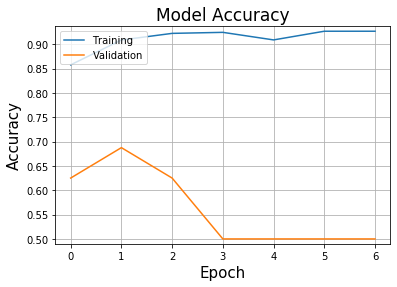

In [15]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']


# Plot training & validation Accuracy values
ylim_pad = [0.01, 0.1]

y1 = history.history['acc']
y2 = history.history['val_acc']
min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]
plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()


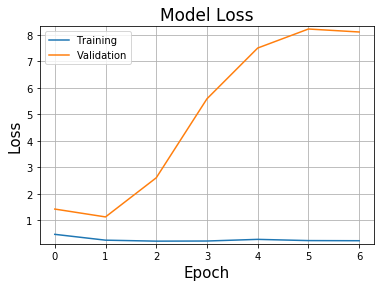

In [16]:
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()



# Evaluating model

In [17]:
# Display the models generated
!ls model

01-val_acc-0.50-val_loss-6.44.hdf5 01-val_acc-0.69-val_loss-2.26.hdf5
01-val_acc-0.56-val_loss-2.10.hdf5 02-val_acc-0.56-val_loss-3.55.hdf5
01-val_acc-0.62-val_loss-1.07.hdf5 02-val_acc-0.69-val_loss-1.13.hdf5
01-val_acc-0.62-val_loss-1.43.hdf5 03-val_acc-0.75-val_loss-3.24.hdf5


In [18]:
dir_name = r"model/"
model_names = os.listdir(dir_name)
for i in range(len(model_names)):
    print(i, model_names[i])

0 02-val_acc-0.56-val_loss-3.55.hdf5
1 01-val_acc-0.62-val_loss-1.07.hdf5
2 01-val_acc-0.69-val_loss-2.26.hdf5
3 01-val_acc-0.56-val_loss-2.10.hdf5
4 02-val_acc-0.69-val_loss-1.13.hdf5
5 01-val_acc-0.62-val_loss-1.43.hdf5
6 03-val_acc-0.75-val_loss-3.24.hdf5
7 01-val_acc-0.50-val_loss-6.44.hdf5


In [19]:
model_file = dir_name + model_names[0]

In [20]:
import keras

In [21]:
model = keras.models.load_model(model_file)

In [22]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 34s 34s/step
Loss     : 2.22  
Accuracy : 68.91%


In [23]:
import cv2

In [24]:
def show_predictions(y_img_batch, y_true, y_pred, class_map, testing_dir, count=8, sample=True):

    file_names = test_generator.filenames
    m = {}
    plt.figure(figsize=(12,12))
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(count, 1, i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

    plt.tight_layout()
    plt.show()

In [25]:
import random

In [26]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 68.91%
-----------------------------------


In [27]:
class_map = {v: k for k, v in test_generator.class_indices.items()}

# Show example

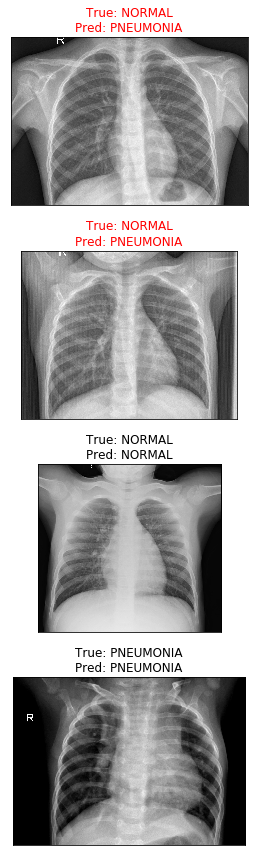

In [28]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, class_map, test_dir, count=4, sample=True)